In [3]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.font_manager as fm
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p, inv_boxcox1p

import warnings

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

sns.set_style("darkgrid")
fontpath = 'C:/Users/TaeSoo/AppData/Local/Microsoft/Windows/Fonts/NanumGothic.ttf'
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['xtick.labelsize'] = 6
pd.options.display.float_format = '{:.5f}'.format

warnings.filterwarnings(action='ignore')

In [4]:
app_train_df = pd.read_csv('application_train.csv')
total_application_df = pd.read_csv('total_merge.csv', index_col = 0)

In [5]:
target = app_train_df['TARGET']

In [4]:
temp_train = total_application_df.iloc[:len(app_train_df),:]
temp_train = pd.concat([temp_train, target], axis = 1)

temp_df = temp_train.copy()
temp_df_object_cols = temp_df.dtypes[temp_df.dtypes == 'O'].index

for col in temp_df_object_cols:
    lbl = LabelEncoder() 
    temp_df[col] = lbl.fit_transform(list(temp_df[col].values)) 

temp_df_cols = temp_df.columns[:] 
temp_df_cor = abs(temp_df[temp_df_cols].corr(method = 'spearman'))
temp_df_cor = pd.DataFrame(temp_df_cor['TARGET']).sort_values('TARGET', ascending = False)
temp_df_cor.columns = ['corr']

<AxesSubplot:>

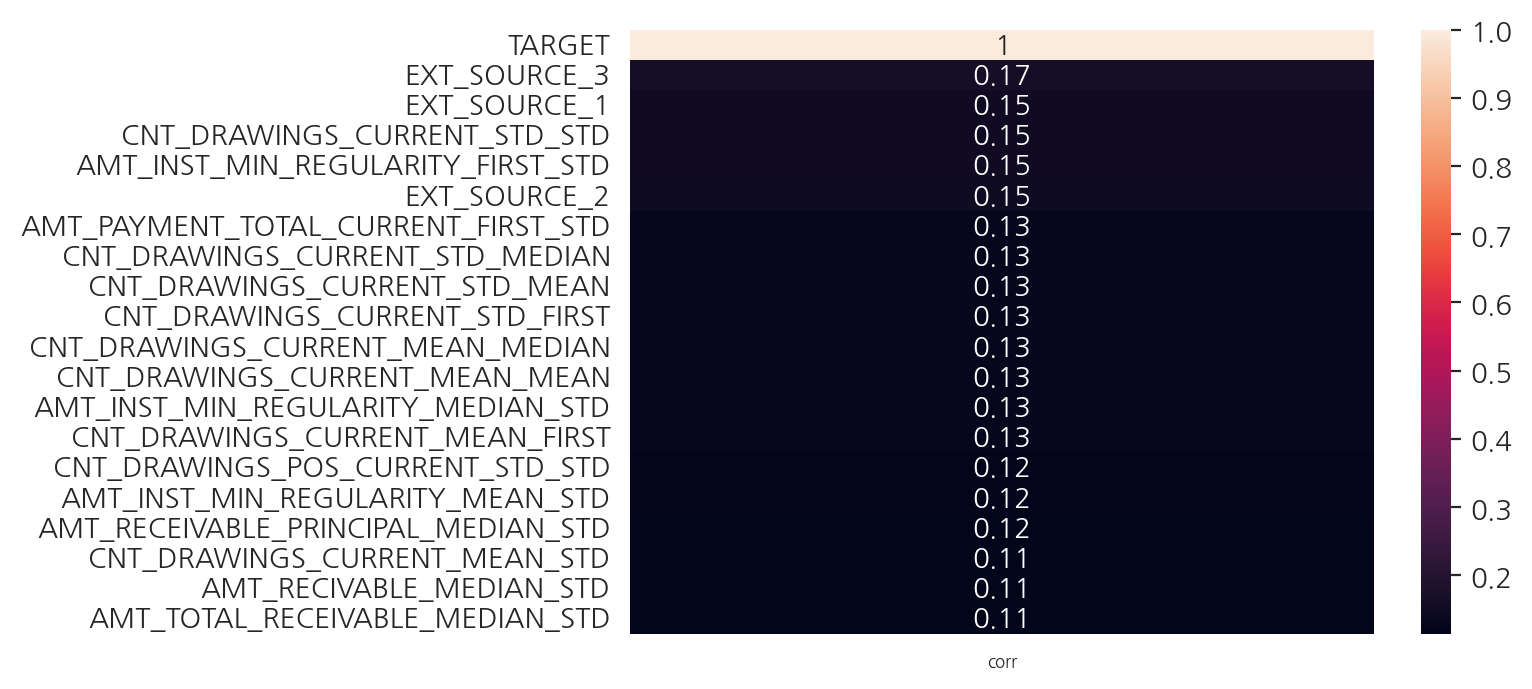

In [5]:
sns.heatmap(temp_df_cor[:20], annot=True)

In [24]:
temp_df_cor.to_csv('total_corr.csv')

In [6]:
total_application_df['SPARE_MONEY'] = total_application_df['AMT_GOODS_PRICE'] - total_application_df['AMT_CREDIT'] # 여유 자금 : 상품 금액 - 대출 총액
total_application_df['INCOME_ANNUITY_PERCENT'] = total_application_df['AMT_INCOME_TOTAL'] / total_application_df['AMT_CREDIT'] # 소득 대비 대출 비율 = 수입 / 대출 총액
total_application_df['CREDIT_TERM'] = total_application_df['AMT_ANNUITY'] / total_application_df['AMT_CREDIT'] # 갚아야하는 기간 = 매달 내야하는 금액 / 대출 총액
total_application_df['DAYS_EMPLOYED_PERCENT'] = total_application_df['DAYS_EMPLOYED'] / total_application_df['AGE'] # 나이 대비 근무일 수

In [7]:
def encoding_scaling (df) :
    le = LabelEncoder()
    le_count = 0

    for col in df:
        if df[col].dtype == 'object':
            if len(list(df[col].unique())) >= 2:
                le.fit_transform(df[col])
                le_count += 1
                
    print('%d columns were label encoded.' % le_count)
    
    df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].apply(lambda x : 1 if x == 'Lower secondary' 
                                                                          else 2 if x == 'Secondary / secondary special' 
                                                                          else 3 if x == 'Higher education'
                                                                          else 4 if x == 'Incomplete higher'
                                                                          else 5)

    df = pd.get_dummies(df)

    df['AMT_INCOME_TOTAL'] = boxcox1p(df['AMT_INCOME_TOTAL'], 0.00001) 
    df['AMT_CREDIT'] = boxcox1p(df['AMT_CREDIT'], 0.125) 
    df['AMT_ANNUITY'] = boxcox1p(df['AMT_ANNUITY'], 0.01) 
    df['AMT_GOODS_PRICE'] = boxcox1p(df['AMT_GOODS_PRICE'], 0.3) 
    df['REGION_POPULATION_RELATIVE'] = boxcox1p(df['REGION_POPULATION_RELATIVE'], 0.001) 
    df['DAYS_EMPLOYED'] = boxcox1p(df['DAYS_EMPLOYED'], 0.15) 
    df['DAYS_REGISTRATION'] = boxcox1p(df['DAYS_REGISTRATION'], 0.6) 
    df['DAYS_ID_PUBLISH'] = boxcox1p(df['DAYS_ID_PUBLISH'], 1.75) 
    df['OWN_CAR_AGE'] = boxcox1p(df['OWN_CAR_AGE'], 0.03) 
    df['CNT_FAM_MEMBERS'] = boxcox1p(df['CNT_FAM_MEMBERS'], 0.2) 

    return df

In [8]:
total_application_df = encoding_scaling(total_application_df)

66 columns were label encoded.


In [9]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc
import re

In [10]:
merged_train = total_application_df.iloc[:len(app_train_df),:]
merged_test = total_application_df.iloc[len(app_train_df):,:]

In [11]:
def lgb_modeling (train, test, target) :
    train_ids = train['SK_ID_CURR']
    test_ids = test['SK_ID_CURR']

    train.reset_index(drop = True, inplace = True)
    target.reset_index(drop = True, inplace = True)

    train, test = train.align(test, join = 'inner', axis = 1)

    train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    random_state = 14
    n_folds = 5
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = random_state)

    feature_names = list(train.columns)
    train = np.array(train)
    test = np.array(test)
    feature_importance_values = np.zeros(len(feature_names))
    test_predictions = np.zeros(test.shape[0])
    out_of_fold = np.zeros(train.shape[0])
    valid_scores = []
    train_scores = []

    for train_indices, valid_indices in k_fold.split(train) :

        # Training data for the fold
        train_features, train_labels = train[train_indices], target[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = train[valid_indices], target[valid_indices]
            
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                    class_weight = 'balanced', learning_rate = 0.05, 
                                    reg_alpha = 0.1, reg_lambda = 0.1, 
                                    subsample = 0.8, n_jobs = -1, random_state = random_state)
            
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                    eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                    eval_names = ['valid', 'train'],
                    early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
            
        # Make predictions
        test_predictions += model.predict_proba(test, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
            
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
            
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        print(valid_score)
        valid_scores.append(valid_score)
        train_scores.append(train_score)
            
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
    
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
        
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
        
    # Overall validation score
    valid_auc = roc_auc_score(target, out_of_fold)
        
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
        
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    return submission, feature_importances, metrics

In [12]:
submission, feature_importances, metrics = lgb_modeling (merged_train, merged_test, target)

[200]	train's auc: 0.832232	train's binary_logloss: 0.513114	valid's auc: 0.778443	valid's binary_logloss: 0.53623
0.7792503939185942
[200]	train's auc: 0.830279	train's binary_logloss: 0.515465	valid's auc: 0.784967	valid's binary_logloss: 0.533756
0.7860137116219796
[200]	train's auc: 0.829914	train's binary_logloss: 0.516155	valid's auc: 0.788501	valid's binary_logloss: 0.534437
0.7889678095426991
[200]	train's auc: 0.831538	train's binary_logloss: 0.513797	valid's auc: 0.777183	valid's binary_logloss: 0.535541
[400]	train's auc: 0.869363	train's binary_logloss: 0.47138	valid's auc: 0.778225	valid's binary_logloss: 0.509578
0.7782944194121442
[200]	train's auc: 0.830796	train's binary_logloss: 0.514738	valid's auc: 0.780674	valid's binary_logloss: 0.53224
[400]	train's auc: 0.868542	train's binary_logloss: 0.472819	valid's auc: 0.781656	valid's binary_logloss: 0.505461
0.7818946896472098


In [13]:
submission.to_csv('total_application_result1.csv', index = False)

In [14]:
metrics

,fold,train,valid
0,0,0.84886,0.77925
1,1,0.84637,0.78601
2,2,0.84933,0.78897
3,3,0.87129,0.77829
4,4,0.86493,0.78189
5,overall,0.85616,0.78275


In [15]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

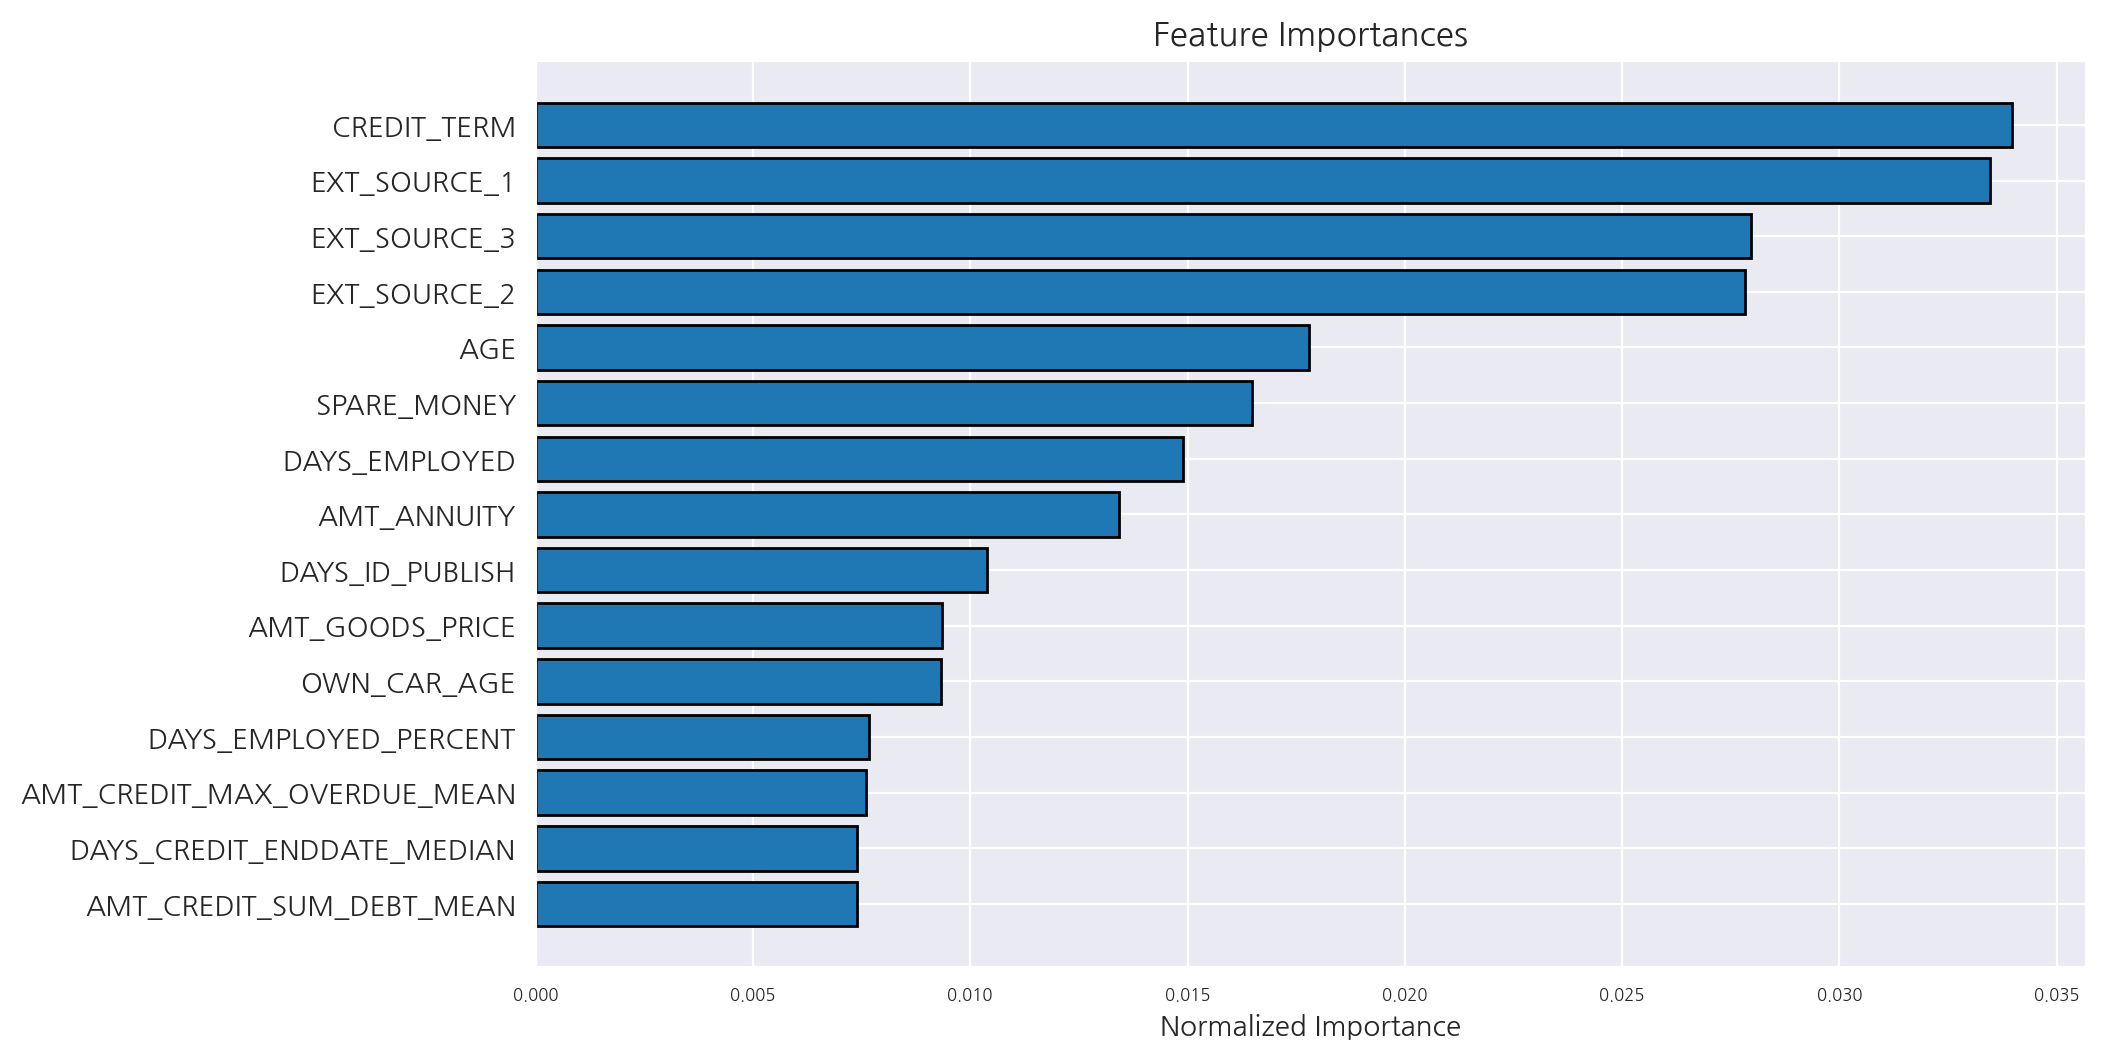

,index,feature,importance,importance_normalized
0,754,CREDIT_TERM,333.60000,0.03396
1,28,EXT_SOURCE_1,328.60000,0.03346
2,30,EXT_SOURCE_3,274.60000,0.02796
3,29,EXT_SOURCE_2,273.40000,0.02784
4,105,AGE,174.80000,0.01780
5,752,SPARE_MONEY,162.00000,0.01649
6,8,DAYS_EMPLOYED,146.40000,0.01491
7,4,AMT_ANNUITY,131.80000,0.01342
8,10,DAYS_ID_PUBLISH,102.00000,0.01038
9,5,AMT_GOODS_PRICE,91.80000,0.00935


In [18]:
pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', None)

plot_feature_importances(feature_importances)

In [17]:
feature_importances.to_csv('total_feature_importances.csv')